In [208]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr

# Grid radars based on date and time of interest

In [255]:
filename = "C:/Users/omitu/Desktop/KHGX/KHGX20220811_000920_V06"
radar = pyart.io.read(filename)
radar.fields.keys()

#Set weighting function
weight_func='Barnes' #nearest, Cressman

#Create a gatefilter
gfilter = pyart.filters.GateFilter(radar)
gfilter.exclude_below('cross_correlation_ratio',0.8)
gfilter.exclude_below('reflectivity',-20)


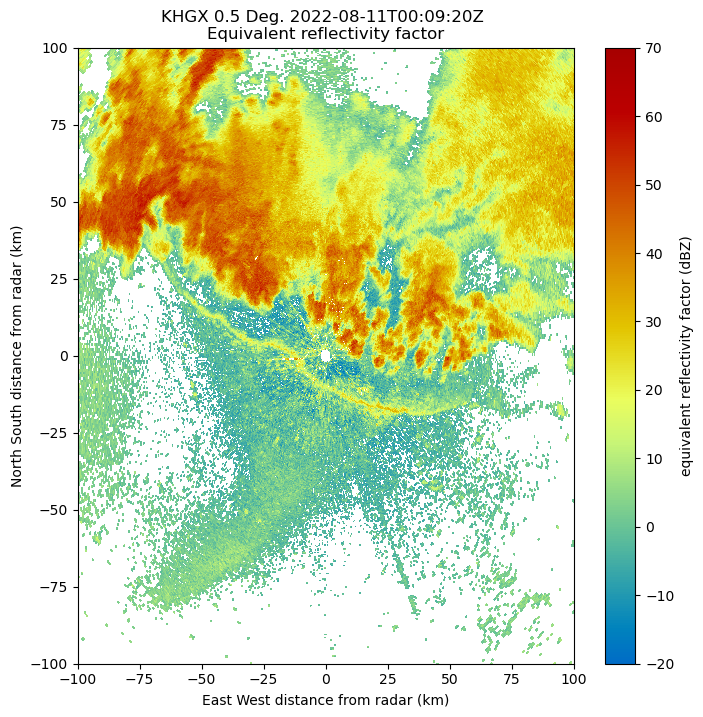

In [257]:
fig = plt.figure(figsize=(8,8))
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity',sweep=0,vmin=-20,vmax=70)
display.set_limits(xlim=(-100,100),ylim=(-100,100))
#plt.savefig('Raw_Z.png')

In [258]:
#KDP calc
kdp_calc = True

#Calculate KDP if desired
if(kdp_calc):
    kdp_vulpiani = pyart.retrieve.kdp_vulpiani(radar, gatefilter=None, band='S', windsize=10, n_iter=10, interp=False,parallel=True)
    radar.add_field('kdp', kdp_vulpiani[0])

In [259]:
#Create a grid based on our radar object (z,y,x)
#Grid shape is number of points in each dimension
#Grid limits are the dimension limits in meters

grid = pyart.map.grid_from_radars(
    radar,
    grid_shape=(41, 401, 401),
    gridding_algo = 'map_gates_to_grid',
    weighting_function = weight_func,
    gatefilters = gfilter,
    grid_limits=(
        (
            0.0,
            20000,
        ),
        (-100000.0, 100000.0),
        (-100000, 100000.0),
    ),
)

In [260]:
radar_grid = grid.to_xarray()

# Filter convective cells based on date and time of interest

In [261]:
tracked_cells = xr.open_dataset('C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/stats/trackstats_20220801.0000_20220831.2359.nc')
tracked_cells

<xarray.Dataset>
Dimensions:                  (tracks: 11705, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 11701 11702 11703 11704
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 ...
    base_time                (tracks, times) datetime64[ns] ...
    meanlat                  (tracks, times) float32 ...
    meanlon                  (tracks, times) float32 ...
    area                     (tracks, times) float32 ...
    cloudnumber              (tracks, times) float64 ...
    ...                       ...
    start_split_tracknumber  (tracks) float64 ...
    start_split_timeindex    (tracks) float64 ...
    start_split_cloudnumber  (tracks) float64 ...
    end_merge_tracknumber    (tracks) float64 ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [262]:
# Define your time range
start_time = np.datetime64('2022-08-11T00:09:00')
end_time = np.datetime64('2022-08-11T00:09:59')

# Create a mask where base_time is within the specified range
time_mask = (tracked_cells.start_basetime >= start_time) & (tracked_cells.start_basetime <= end_time)

# Apply this mask across the 'tracks' dimension
filtered_ds = tracked_cells.where(time_mask, drop=True)
filtered_ds

<xarray.Dataset>
Dimensions:                  (tracks: 4, times: 100)
Coordinates:
  * tracks                   (tracks) int64 2881 2882 2883 2884
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) float64 1.0 8.0 27.0 19.0
    base_time                (tracks, times) datetime64[ns] 2022-08-11T00:09:...
    meanlat                  (tracks, times) float32 29.86 nan nan ... nan nan
    meanlon                  (tracks, times) float32 -95.99 nan nan ... nan nan
    area                     (tracks, times) float32 110.2 nan nan ... nan nan
    cloudnumber              (tracks, times) float64 6.0 nan nan ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 2.866e+03 2.853e+03 nan nan
    start_split_timeindex    (tracks) float64 3.0 7.0 nan nan
    start_split_cloudnumber  (tracks) float64 1.0 6.0 nan nan
    end_merge_tracknumber    (tracks) float64 2.868e+03 nan 2.975e+03 nan
    end_merge_timeindex      (tracks) float64 5.0 nan 5.0 nan
    end_merge_cloudnumber    (tracks) float64 2.0 nan 1.0 nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [263]:
# Calculate cell area

filtered_ds.cell_area.std()

<xarray.DataArray 'cell_area' ()>
array(27.21972084)

# Filter gridded radars based on convective cells

In [264]:
radar_grid

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 401, x: 401)
Coordinates:
  * time                          (time) object 2022-08-11 00:09:20.030000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 28.57 28.57 ... 30.37 30.37
    lon                           (y, x) float64 -96.1 -96.1 ... -94.04 -94.04
  * y                             (y) float64 -1e+05 -9.95e+04 ... 1e+05
  * x                             (x) float64 -1e+05 -9.95e+04 ... 1e+05
Data variables:
    clutter_filter_power_removed  (time, z, y, x) float32 nan nan ... nan nan
    differential_phase            (time, z, y, x) float32 nan nan ... nan nan
    spectrum_width                (time, z, y, x) float32 nan nan ... nan nan
    kdp                           (time, z, y, x) float64 nan nan ... nan nan
    cross_correlation_ratio       (time, z, y, x) float32 nan nan ... nan nan
    differential_reflectivity     (time, z, y, x) float32 nan nan ... nan nan
    velocity                      (time, z, y, x) float32 nan nan ... nan nan
    reflectivity                  (time, z, y, x) float32 nan nan ... nan nan
    ROI                           (time, z, y, x) float32 3.703e+03 ... 4.703...

In [265]:
filtered_ds.isel(tracks=1)

<xarray.Dataset>
Dimensions:                  (times: 100)
Coordinates:
    tracks                   int64 2882
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           float64 8.0
    base_time                (times) datetime64[ns] 2022-08-11T00:09:20.02999...
    meanlat                  (times) float32 29.56 29.55 29.49 ... nan nan nan
    meanlon                  (times) float32 -95.13 -95.13 -95.23 ... nan nan
    area                     (times) float32 60.25 44.75 71.75 ... nan nan nan
    cloudnumber              (times) float64 12.0 13.0 12.0 9.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  float64 2.853e+03
    start_split_timeindex    float64 7.0
    start_split_cloudnumber  float64 6.0
    end_merge_tracknumber    float64 nan
    end_merge_timeindex      float64 nan
    end_merge_cloudnumber    float64 nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [266]:
# Extract the coordinates from the convective cell data
latitudes = filtered_ds.cell_meanlat.values[~np.isnan(filtered_ds.cell_meanlat.values)]
longitudes = filtered_ds.cell_meanlon.values[~np.isnan(filtered_ds.cell_meanlon.values)]

In [267]:
# Buffer size (example: 0.01 degrees)
lat_buffer = 0.01
lon_buffer = 0.01

# Function to add buffers around points to reach a target number of points
def add_buffers(arr, buffer_size, target_length):
    # Calculate how many buffers to add around each point to approximate the target length
    num_buffers_per_point = (target_length - len(arr)) // (2 * len(arr))  # 2 buffers per original point (add and subtract)
    additional_points_needed = target_length - len(arr) - (2 * num_buffers_per_point * len(arr))
    
    new_points = []
    for point in arr:
        new_points.append(point)  # Add the original point
        # Generate buffers around each point
        for i in range(1, num_buffers_per_point + 1):
            new_points.append(point + i * buffer_size)
            new_points.append(point - i * buffer_size)
    
    # If additional points are needed, add them around the first point
    for i in range(1, additional_points_needed // 2 + 1):
        new_points.append(arr[0] + (num_buffers_per_point + i) * buffer_size)
        new_points.append(arr[0] - (num_buffers_per_point + i) * buffer_size)
    
    # Ensure the length matches the target length, trim if necessary
    return np.array(new_points[:target_length])

# Add buffers and generate new latitudes and longitudes
new_latitudes = add_buffers(latitudes, lat_buffer, 45)
new_longitudes = add_buffers(longitudes, lon_buffer, 45)

print("New Latitudes:", new_latitudes)
print("New Longitudes:", new_longitudes)


New Latitudes: [29.85544  29.564566 29.552328 29.491331 29.496922 29.415575 29.41283
 29.317867 29.316708 29.314928 29.312027 29.307804 29.308867 29.289976
 29.28445  29.27879  29.273699 29.268045 29.257816 29.244074 29.230116
 29.21522  29.20937  29.19277  29.177448 29.157825 29.13612  29.12002
 29.047384 29.043516 29.043987 29.035479 29.02791  29.016937 29.011963
 29.001186 29.1629   29.170334 29.168774 29.152082 29.179125 29.181444
 29.182116 29.184637 29.183865]
New Longitudes: [-95.994514 -95.12617  -95.12754  -95.23273  -95.25691  -95.242065
 -95.25848  -95.245056 -95.25433  -94.09628  -94.10388  -94.11757
 -94.13774  -94.15984  -94.17533  -94.19579  -94.21161  -94.23351
 -94.25086  -94.26793  -94.2849   -94.30929  -94.33986  -94.352745
 -94.36345  -94.360855 -94.36616  -94.378685 -94.31717  -94.3382
 -94.36533  -94.38367  -94.4082   -94.4297   -94.445076 -94.45764
 -93.959915 -93.97216  -93.983406 -93.9998   -94.01444  -94.02376
 -94.02808  -94.03552  -94.03925 ]


In [268]:
import numpy as np
import xarray as xr

# Example latitudes and longitudes of interest
latitudes = new_latitudes
longitudes = new_longitudes

# Assuming radar_grid is your dataset and it has 2D lat and lon coordinates
lat_grid = radar_grid['lat'].values  # 2D array of latitudes
lon_grid = radar_grid['lon'].values  # 2D array of longitudes

selected_data = []

for point_lat, point_lon in zip(latitudes, longitudes):
    # Calculate squared distance to avoid unnecessary sqrt computation for comparison
    distance_squared = (lat_grid - point_lat)**2 + (lon_grid - point_lon)**2
    
    # Find the index of the minimum distance
    min_dist_idx = np.unravel_index(np.argmin(distance_squared), distance_squared.shape)
    
    # Corrected indexing using the 'y' and 'x' dimensions
    nearest_point_data = radar_grid.isel(y=min_dist_idx[0], x=min_dist_idx[1])
    selected_data.append(nearest_point_data)


# selected_data now contains the data points closest to your specified latitudes and longitudes
final_data = xr.concat(selected_data, dim='y', data_vars='all')
final_data_2 = xr.concat(selected_data, dim='x', data_vars='all')
merged_data = final_data.combine_first(final_data_2)

In [269]:
merged_data = merged_data.transpose("z", "y", "x", "time")   # Rearrange dimensions

In [270]:
merged_data

<xarray.Dataset>
Dimensions:                       (y: 45, time: 1, z: 41, x: 45)
Coordinates:
  * time                          (time) object 2022-08-11 00:09:20.030000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
  * y                             (y) float64 4.3e+04 1.05e+04 ... -3.15e+04
  * x                             (x) float64 -8.85e+04 -4.5e+03 ... 1e+05 1e+05
Data variables:
    clutter_filter_power_removed  (z, y, x, time) float32 -6.0 -6.0 ... nan nan
    differential_phase            (z, y, x, time) float32 111.6 111.6 ... nan
    spectrum_width                (z, y, x, time) float32 nan 0.8047 ... nan nan
    kdp                           (z, y, x, time) float64 1.607 1.607 ... nan
    cross_correlation_ratio       (z, y, x, time) float32 0.9794 0.9794 ... nan
    differential_reflectivity     (z, y, x, time) float32 1.552 1.552 ... nan
    velocity                      (z, y, x, time) float32 nan -6.28 ... nan nan
    reflectivity                  (z, y, x, time) float32 50.52 50.52 ... nan
    ROI                           (z, y, x, time) float32 2.577e+03 ... 3.745...

# COntinue with CFAD

In [271]:
#CFAD settings
zlims=[-20, 65]
zdrlims=[-1, 3]
rholims=[0.9, 1.02]
kdplims=[-1,3]
#lims = [-50000,0,-75000,30000]
lims=[-100000,-50000,-50000,50000]
#lims = [-50000,50000,-50000,50000]
ymax=10
norm_opt = 2 #1) Normalize at each height only, 2) Normalize across all heights

#CFAD increment
dz = 5
dzdr = 0.5
drho = 0.0025
dkdp = 0.1

In [272]:
# Function to apply masking and squeezing
def process_variable(data_array):
    # Extract the numpy array from the DataArray
    np_array = data_array.values
    
    # Define the mask condition
    mask_condition = np.isnan(np_array)
    
    # Apply the mask to create a masked array
    masked_array_np = np.ma.masked_where(mask_condition, np_array)
    
    # Squeeze the masked array to remove the singleton dimension
    squeezed_masked_array = np.squeeze(masked_array_np)
    
    # Return the processed masked array
    return squeezed_masked_array

In [273]:
differential_reflectivity = merged_data['differential_reflectivity']
masked_differential_reflectivity = process_variable(differential_reflectivity)

kdp = merged_data['kdp']
masked_kdp = process_variable(kdp)

cross_correlation_ratio = merged_data['cross_correlation_ratio']
masked_cross_correlation_ratio = process_variable(cross_correlation_ratio)

reflectivity = merged_data['reflectivity']
masked_reflectivity = process_variable(reflectivity)

In [274]:
[X, Y] = np.meshgrid(merged_data.x, merged_data.y)

In [275]:
def cfad_calc(data,bins,lims,norm_opt=1):
    #lims is a 4-element list or tuple (xmin, xmax, ymin, ymax). 
    #lims = 0: Use whole domain
    #bins: array of bin edge locations
    #norm_opt: 1) Normalize at each level only, 2) Normalize by max count
    
    #Initialize histogram
    hist2d = np.zeros((np.size(bins)-1,data.shape[0]))
    
    #Check if the user wants a limited domain
    limit_domain = np.size(lims) > 1
    
    if(limit_domain):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        
    #loop over all heights
    for lev in range(data.shape[0]):
        if(limit_domain):
            data_hist = np.ma.compressed(data[lev,a])
        else:
            data_hist = np.ma.compressed(data[lev,:])
        
        #Calculate histogram
        histogram, bin_edges = np.histogram(np.ravel(data_hist), bins)
        
        #Normalize histogram
        if(norm_opt == 1):
            if(np.sum(histogram) > 0):
                hist2d[:,lev] = histogram/np.sum(histogram)
        elif(norm_opt == 2):
            hist2d[:,lev] = histogram
        
    if(norm_opt == 2):
        #Normalize by maximum count across all heights
        hist2d /= np.max(hist2d)
                
    bin_ctrs = (bins[:-1]+bins[1:])/2
    
    return hist2d,bin_ctrs
    
def vert_stats(data,lims):
    if(np.size(lims) > 1):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        data_mean = np.ma.median(data[:,a],axis=1)
    else:
        data_mean = np.ma.mean(np.ma.mean(data,axis=2),axis=1)
        
    return data_mean
    
dzgrid = grid.z["data"][2]-grid.z["data"][1]
#CFAD X
data =  masked_reflectivity
binsZ = np.arange(zlims[0], zlims[1], dz)

[hist_Z, Zctr] = cfad_calc(data,binsZ,lims,norm_opt)
#hist_Z /= dz
meanZ = vert_stats(data,lims)

#CFAD ZDR
data = masked_differential_reflectivity
binsZDR = np.arange(zdrlims[0], zdrlims[1], dzdr)
[hist_ZDR, ZDRctr] = cfad_calc(data,binsZDR,lims,norm_opt)
#hist_ZDR /= (dzdr*10)
meanZDR = vert_stats(data,lims)

#CFAD rhohv
data = masked_cross_correlation_ratio
binsrho = np.arange(rholims[0], rholims[1], drho)
[hist_rho, rhoctr] = cfad_calc(data,binsrho,lims,norm_opt)
#hist_rho /= (drho*10000)
meanrho = vert_stats(data,lims)

#CFAD KDP
if(kdp_calc):
    data = masked_kdp
    binskdp = np.arange(kdplims[0], kdplims[1], dkdp)
    [hist_kdp,kdpctr] = cfad_calc(data,binskdp,lims,norm_opt)
    #hist_kdp /= (dkdp*100)
    meankdp = vert_stats(data,lims)

In [276]:
def cfad_calc(data,bins,lims,norm_opt=1):
    #lims is a 4-element list or tuple (xmin, xmax, ymin, ymax). 
    #lims = 0: Use whole domain
    #bins: array of bin edge locations
    #norm_opt: 1) Normalize at each level only, 2) Normalize by max count
    
    #Initialize histogram
    hist2d = np.zeros((np.size(bins)-1,data.shape[0]))
    
    #Check if the user wants a limited domain
    limit_domain = np.size(lims) > 1
    
    if(limit_domain):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        
    #loop over all heights
    for lev in range(data.shape[0]):
        if(limit_domain):
            data_hist = np.ma.compressed(data[lev,a,b])
        else:
            data_hist = np.ma.compressed(data[lev,:,:])
        
        #Calculate histogram
        histogram, bin_edges = np.histogram(np.ravel(data_hist), bins)
        
        #Normalize histogram
        if(norm_opt == 1):
            if(np.sum(histogram) > 0):
                hist2d[:,lev] = histogram/np.sum(histogram)
        elif(norm_opt == 2):
            hist2d[:,lev] = histogram
        
    if(norm_opt == 2):
        #Normalize by maximum count across all heights
        hist2d /= np.max(hist2d)
                
    bin_ctrs = (bins[:-1]+bins[1:])/2
    
    return hist2d,bin_ctrs
    
def vert_stats(data,lims):
    if(np.size(lims) > 1):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        data_mean = np.ma.median(data[:,a,b],axis=1)
    else:
        data_mean = np.ma.mean(np.ma.mean(data,axis=2),axis=1)
        
    return data_mean
    
dzgrid = grid.z["data"][2]-grid.z["data"][1]
#CFAD X
data =  masked_reflectivity
binsZ = np.arange(zlims[0], zlims[1], dz)

[hist_Z, Zctr] = cfad_calc(data,binsZ,lims,norm_opt)
#hist_Z /= dz
meanZ = vert_stats(data,lims)

#CFAD ZDR
data = masked_differential_reflectivity
binsZDR = np.arange(zdrlims[0], zdrlims[1], dzdr)
[hist_ZDR, ZDRctr] = cfad_calc(data,binsZDR,lims,norm_opt)
#hist_ZDR /= (dzdr*10)
meanZDR = vert_stats(data,lims)

#CFAD rhohv
data = masked_cross_correlation_ratio
binsrho = np.arange(rholims[0], rholims[1], drho)
[hist_rho, rhoctr] = cfad_calc(data,binsrho,lims,norm_opt)
#hist_rho /= (drho*10000)
meanrho = vert_stats(data,lims)

#CFAD KDP
if(kdp_calc):
    data = masked_kdp
    binskdp = np.arange(kdplims[0], kdplims[1], dkdp)
    [hist_kdp,kdpctr] = cfad_calc(data,binskdp,lims,norm_opt)
    #hist_kdp /= (dkdp*100)
    meankdp = vert_stats(data,lims)

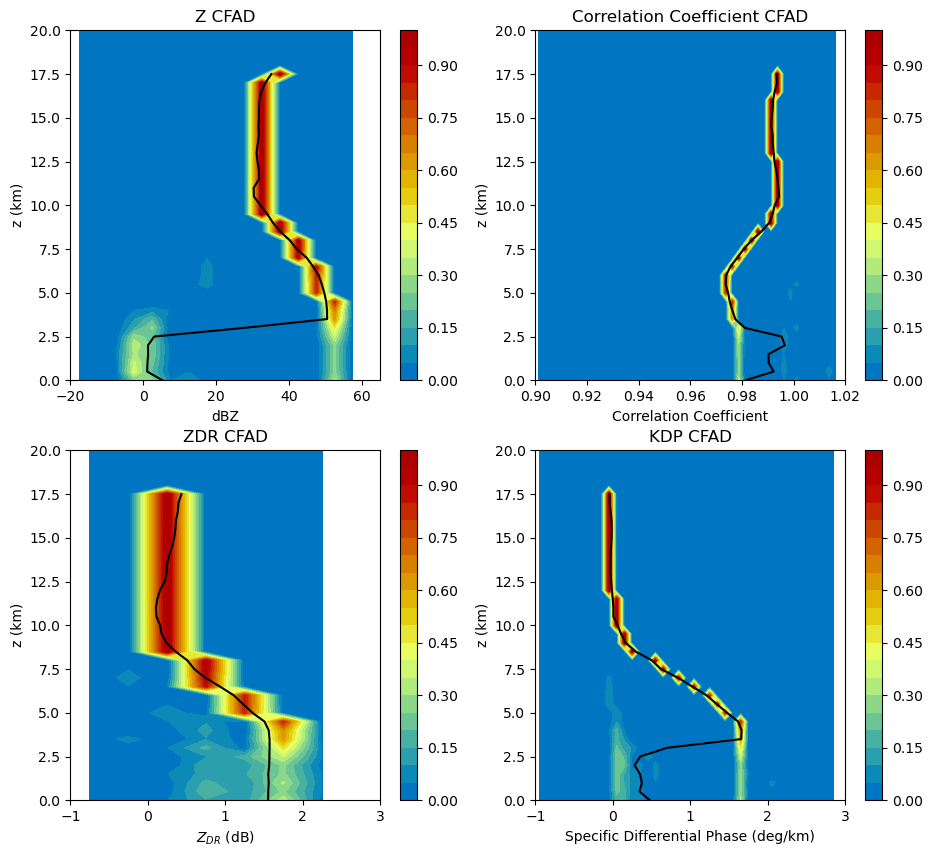

In [277]:
#Plotting levels for contours
ymax=20
fig,ax = plt.subplots(2,2,figsize=(11,10))
[z,b]=np.meshgrid(grid.z["data"],Zctr)
pcm=ax[0,0].contourf(b,z/1000,hist_Z,levels=20,cmap='pyart_HomeyerRainbow')
ax[0,0].plot(meanZ,grid.z["data"]/1000,'-k')
#ax[0,0].contour(b,z/1000,hist_Z,levels=np.arange(0.05,1,0.05),colors='k')
ax[0,0].set_xlabel('dBZ')
ax[0,0].set_ylabel('z (km)')
ax[0,0].set_title('Z CFAD')
#ax[0,0].set_title('Z CFAD (% of Data per dBZ per km)')
ax[0,0].set_xlim(zlims)
ax[0,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,0])

[z,b]=np.meshgrid(grid.z["data"],ZDRctr)
pcm=ax[1,0].contourf(b,z/1000,hist_ZDR,levels=20,cmap='pyart_HomeyerRainbow')
#ax[1,0].contour(b,z/1000,hist_ZDR,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[1,0].plot(meanZDR,grid.z["data"]/1000,'-k')
ax[1,0].set_xlabel('$Z_{DR}$ (dB)')
ax[1,0].set_ylabel('z (km)')
#ax[1,0].set_title('ZDR CFAD (% of Data per 0.1 dB per km)')
ax[1,0].set_title('ZDR CFAD')
ax[1,0].set_xlim(zdrlims)
ax[1,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[1,0])

[z,b]=np.meshgrid(grid.z["data"],rhoctr)
pcm=ax[0,1].contourf(b,z/1000,hist_rho,levels=20,cmap='pyart_HomeyerRainbow')
#ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[0,1].plot(meanrho,grid.z["data"]/1000,'-k')
ax[0,1].set_xlabel('Correlation Coefficient')
ax[0,1].set_ylabel('z (km)')
#ax[0,1].set_title('Correlation Coefficient CFAD (% of Data per 0.001 CC per km)')
ax[0,1].set_title('Correlation Coefficient CFAD')
ax[0,1].set_xlim(rholims)
ax[0,1].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,1])

if(kdp_calc):
    [z,b]=np.meshgrid(grid.z["data"],kdpctr)
    pcm=ax[1,1].contourf(b,z/1000,hist_kdp,levels=20,cmap='pyart_HomeyerRainbow')
    #ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
    ax[1,1].plot(meankdp,grid.z["data"]/1000,'-k')
    ax[1,1].set_xlabel('Specific Differential Phase (deg/km)')
    #ax[1,1].set_title('KDP CFAD (% of Data per 0.01 deg/km per km)')
    ax[1,1].set_title('KDP CFAD')
    ax[1,1].set_ylabel('z (km)')
    ax[1,1].set_ylim(0,ymax)
    ax[1,1].set_xlim(kdplims)
    fig.colorbar(pcm, ax=ax[1,1])

fig.savefig('CFAD_norm_1.png')



# Characterize the near-storm environment